# DCGAN ( Deep Convolutional Generative Adversarial Networks ) on MNIST
![img](../notebook_material/dcgan.png)

## MNIST (28*28)
![img](../notebook_material/mnist.jpg)

# Import  

In [13]:
''' basic package '''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm_notebook as tqdm
from utils import *

''' tensorflow package '''
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


# Config 

In [14]:
'''input'''
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
batch_size= 128
img_size=(28, 28)   # (height, width)
img_channel=1       # color image set to 3, grayscale image set to 1
z_dim=100           # demesion of noise vector z for generator input

'''model'''
gf_dim=64 # dimension of generator filters in first conv layer
df_dim=64 # dimension of discriminator filters in first conv layer
          # 一般 gf_dim = df_dim
    
'''train'''
max_iter = 10000

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Train 

### 定義 generator & discriminator 

In [17]:
#### Define model ####
def generator(z, batch_size, img_size, img_channel, is_training, gf_dim=64):
    
    # 預先計算每層逆卷積後 feature maps 長寬
    s_h, s_w = img_size[0], img_size[1]                           #28
    s_h2, s_w2 = conv_out_size(s_h, 2), conv_out_size(s_w, 2)     #14
    s_h4, s_w4 = conv_out_size(s_h2, 2), conv_out_size(s_w2, 2)   #7
    s_h8, s_w8 = conv_out_size(s_h4, 2), conv_out_size(s_w4, 2)   #4
    s_h16, s_w16 = conv_out_size(s_h8, 2), conv_out_size(s_w8, 2) #2
    
    with tf.variable_scope('generator') as scope:
        # 將 z 投影、reshape 成可以被 deconv 的樣子
        # 請輸入程式碼
        z = linear(z, gf_dim*8*s_h16*s_w16, 'gen_h0_lin')
        h0 = tf.reshape(z, [-1, s_h16, s_w16, gf_dim*8])
        h0 = tf.nn.relu(tf.layers.batch_normalization(h0, training=is_training, name ='gen_bn0'))
        
        h1 = deconv2d(h0, [batch_size, s_h8, s_w8, gf_dim*4], name='gen_h1')
        h1 = tf.nn.relu(tf.layers.batch_normalization(h1, training=is_training, name ='gen_bn1'))
        
        h2 = deconv2d(h1, [batch_size, s_h4, s_w4, gf_dim*2], name='gen_h2')
        h2 = tf.nn.relu(tf.layers.batch_normalization(h2, training=is_training, name ='gen_bn2'))
        
        h3 = deconv2d(h2, [batch_size, s_h2, s_w2, gf_dim], name='gen_h3')
        h3 = tf.nn.relu(tf.layers.batch_normalization(h3, training=is_training, name ='gen_bn3'))
        
        h4 = deconv2d(h3,[batch_size, s_h, s_w, img_channel], name='gen_h4')
        
        return tf.nn.sigmoid(h4)
        
        
def discriminator(image, batch_size, is_training, df_dim=64):
    
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE) as scope:
        # 請輸入程式碼
        h0 = lrelu(conv2d(image, df_dim*1, name='dis_h0'))
        
        h1 = lrelu(conv2d(h0, df_dim*2, name='dis_h1'))
        h1 = tf.layers.batch_normalization(h1, training=is_training, name='dis_bn1')
        
        h2 = lrelu(conv2d(h1, df_dim*4, name='dis_h2'))
        h2 = tf.layers.batch_normalization(h2, training=is_training, name='dis_bn2')
        
        h3 = lrelu(conv2d(h2, df_dim*8, name='dis_h3'))
        h3 = tf.layers.batch_normalization(h3, training=is_training, name='dis_bn3')
        
        h4 = linear(tf.reshape(h3, [batch_size, -1]), 1, 'dis_h4_lin')
        
        
        return tf.nn.sigmoid(h4), h4

### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行



In [18]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    #### placeholder ####
    z = tf.placeholder(name='z', dtype=tf.float32, shape=[None, z_dim])
    input_img = tf.placeholder(name='real_img', dtype=tf.float32, shape=[batch_size, img_size[0], img_size[1], img_channel])
    is_training = tf.placeholder(dtype=tf.bool, shape=[])

    
    #### GAN model output ####
    # 請完成以下程式碼
    G_sample = generator(z, batch_size, img_size, img_channel, is_training, gf_dim=gf_dim)
    D_real, D_real_logit = discriminator(input_img, batch_size, is_training, df_dim=df_dim)
    D_fake, D_fake_logit = discriminator(G_sample, batch_size, is_training, df_dim=df_dim)
    
    #### loss ####
    # 請完成以下程式碼
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logit,labels=tf.ones_like(D_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit,labels=tf.zeros_like(D_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit,labels=tf.ones_like(D_fake)))
    
    #### variable list ####
    varList = tf.trainable_variables()
    G_varList = [var for var in varList if 'generator' in var.name]
    D_varList = [var for var in varList if 'discriminator' in var.name]
    
    #### update ####
    G_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator') #使用內建的 batch normalization layer, 必須執行
    with tf.control_dependencies(G_update_ops):                                    #tf.GraphKeys.UPDATE_OPS 才會更新到 BN 層的 mean, variance
        G_update = tf.train.AdamOptimizer().minimize(G_loss, var_list=G_varList) 
        
    D_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    with tf.control_dependencies(D_update_ops):
        D_update = tf.train.AdamOptimizer().minimize(D_loss, var_list=D_varList)
        
    
    #### other ####
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

### Tensorflow- 初始化模型

In [19]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [20]:
def sample_Z(m, n):
        return np.random.uniform(-1., 1., size=[m, n])

# only print out 16 images
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    fig_pos = 0
    rnd_idx = np.random.choice(samples.shape[0], 16)
    for i, sample in enumerate(samples):
        if i in rnd_idx: 
            ax = plt.subplot(gs[fig_pos])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(img_size[0], img_size[1]), cmap='Greys_r')
            fig_pos+=1
    return fig

A Jupyter Widget

Iter: 0
D loss: 1.364
G_loss: 7.394


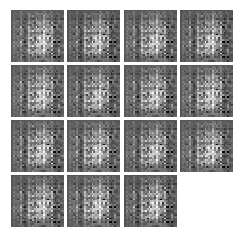

############################


KeyboardInterrupt: 

In [23]:
if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
train_iter_bar = tqdm(range(max_iter), desc="train_iter", unit="iter", leave=False)
for it in train_iter_bar:

    #### train ####
    X, _ = mnist.train.next_batch(batch_size)
    X = X.reshape(batch_size, img_size[0], img_size[1], img_channel)

    # 請完成以下程式碼
    _, D_loss_curr = sess.run([D_update, D_loss], feed_dict={input_img:X, z:sample_Z(batch_size, z_dim), is_training: True})
    _, G_loss_curr = sess.run([G_update, G_loss], feed_dict={z:sample_Z(batch_size, z_dim), is_training: True})
    _, G_loss_curr = sess.run([G_update, G_loss], feed_dict={z:sample_Z(batch_size, z_dim), is_training: True})
    #讓Generator多學幾次，有時候D會太強
    

    if it % 500 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
                                     
        samples = sess.run(G_sample, feed_dict={z: sample_Z(batch_size, z_dim), is_training: False})
        fig = plot(samples)
        plt.show()
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        print('############################')
        
# 儲存模型
saver.save(sess, 'model/DCGAN.ckpt')

### Tensorflow- 載入模型、生成影像 

In [9]:
saver.restore(sess, 'model/DCGAN.ckpt')

INFO:tensorflow:Restoring parameters from model/DCGAN.ckpt


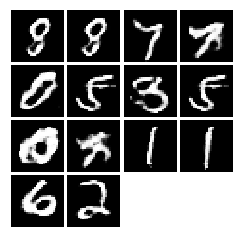

In [17]:
''' Generator 產生一批影像 '''
samples = sess.run(G_sample, feed_dict={z:sample_Z(batch_size, z_dim), is_training:False})
plot(samples)

In [ ]:
os._exit(00)